In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
import requests 
import tqdm
import tarfile
from clint.textui import progress
import os
from pathlib import Path
import pandas as pd
import scipy.io
import json
import shutil
import pickle

c:\programdata\miniconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\programdata\miniconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\programdata\miniconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
import matplotlib.pyplot as plt
import cv2

In [3]:
def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    
    with open(save_path, 'wb') as fd:
        total_length = int(r.headers.get('content-length'))
        
        for chunk in progress.bar(r.iter_content(chunk_size=chunk_size),
                                  expected_size=(total_length/1024) + 1):
            fd.write(chunk)
            fd.flush()
                                  
    return

def extract_file(fname,path='.'):
    if fname.endswith("tar.gz"):
        tar = tarfile.open(fname, "r:gz")
        tar.extractall(path=path)
        tar.close()
    elif fname.endswith("tar"):
        tar = tarfile.open(fname, "r:")
        tar.extractall(path=path)
        tar.close()
    
    return


In [10]:
# Download files

img_url = "http://host.robots.ox.ac.uk/pascal/VOC/voc2010/VOCtrainval_03-May-2010.tar"
annot_url = "http://roozbehm.info/pascal-parts/trainval.tar.gz"

save_path_img = "img_zip"
save_path_annot = "annot_zip"

curr_path = os.getcwd()
path = Path(curr_path)



In [ ]:
save_loc = os.path.join(path.parent,'datasets','PASCAL-VOC',save_path_img)
os.mkdir(save_loc)
download_url(img_url,os.path.join(save_loc,'images.tar'))

save_loc = os.path.join(path.parent,'datasets','PASCAL-VOC',save_path_annot)
os.mkdir(save_loc)
download_url(annot_url,os.path.join(save_loc,'annotations.tar.gz'))



In [14]:
save_loc = os.path.join(path.parent,'datasets','PASCAL-VOC',save_path_annot)
extract_file(os.path.join(save_loc,'annotations.tar.gz'),path = save_loc)

In [15]:
save_loc = os.path.join(path.parent,'datasets','PASCAL-VOC',save_path_img)
extract_file(os.path.join(save_loc+'images.tar'),path = save_loc)

In [7]:
# class_list = os.listdir(save_loc+'\\VOCdevkit\\VOC2010\\ImageSets\\Main')
# class_list = [file.split('_')[0] for file in class_list]
# class_list = list(filter(lambda x: ('val' not in x)and('train' not in x),
#                          class_list))
# class_set = set(class_list)
class_set = set(['aeroplane','bicycle','bird','cat','cow','dog','horse','motorbike','person','sheep'])

In [12]:
anno_destination = os.path.join(path.parent,'datasets','PASCAL-VOC','xybb-objects')
anno_source = os.path.join(path.parent,'datasets','PASCAL-VOC',
                                        save_path_annot,
                                        'Annotations_Part')
img_source = os.path.join(path.parent,'datasets','PASCAL-VOC',
                                       save_path_img,
                                       'VOCdevkit','VOC2010','JPEGImages')

save_loc = os.path.join(path.parent,'datasets','PASCAL-VOC'+save_path_img)
for ob_class in class_set:
                                       
    new_dir = anno_destination+ob_class
    if not os.path.exists(new_dir):
        os.mkdir(new_dir)
    
    if not os.path.exists(new_dir+'\\bbox'):
        os.mkdir(new_dir+'\\bbox')
        
    if not os.path.exists(new_dir+'\\mask'):
        os.mkdir(new_dir+'\\mask')
        
    if not os.path.exists(new_dir+'\\rgb'):
        os.mkdir(new_dir+'\\rgb')
    
    if not os.path.exists(new_dir+'\\numpy'):
        os.mkdir(new_dir+'\\numpy')
    
#for ob_class in class_set:
#    print(ob_class)
    
img_list = pd.read_csv(os.path.join(save_loc+'VOCdevkit','VOC2010','ImageSets','Main','train_trainval.txt'),
                      header=None,index_col=None,sep='\t')


img_list = img_list[0].str.split(' ',expand=True)
img_list.columns = ['img','flag','drop']
img_list.drop(['drop'],axis=1,inplace=True)

for image in img_list.sample(n=100).img:
    mat = scipy.io.loadmat(anno_source+image+'.mat')
    img_file = (img_source+image+'.jpg')
    img_dest = os.path.join(path.parent,'datasets','PASCAL-VOC','scene',image+'.jpg')
    
    if not os.path.exists(img_dest):
        shutil.move(img_file,img_dest)
    label_list = []
    annotation_dict = {}
    item_idx = 0
    for annotation in mat['anno'][0][0][1][0]:
        annotation_dict = {}
        label = annotation[0][0]
        if label not in class_set:
            continue

        if os.path.exists(os.path.join(anno_destination,label,'bbox',image+'.json')):
            
            with open(os.path.join(anno_destination,label,'bbox',image+'.json')) as fp:
                annotation_dict = json.load(fp)
    
            item_idx = max(map(int,annotation_dict.keys()))+1

        annotation_dict[item_idx] = {}
        annotation_dict[item_idx]['mask'] = annotation[2].tolist()
        annotation_dict[item_idx]['bbox'] = np.append(np.min(np.where(annotation[2]==1),
                                                                   axis=1),
                                                   np.max(np.where(annotation[2]==1),
                                                                   axis=1)).tolist()
        annotation_dict[item_idx]['parts'] = {}
        parts_dict = annotation_dict[item_idx]['parts'] 

        if (len(annotation[3])>0)and (len(annotation[3][0])>0):
            for part in annotation[3][0]:

                part_label = part[0][0]
                parts_dict[part_label] = {}
                parts_dict[part_label]['mask'] = part[1].tolist()
                parts_dict[part_label]['bbox'] = np.append(np.min(np.where(part[1]==1),
                                                                          axis=1),
                                                       np.max(np.where(part[1]==1),
                                                              axis=1)).tolist()

        item_idx+=1



        if len(annotation_dict.keys())>0:
            with open(os.path.join(anno_destination,label,'bbox',image+'.json'), 'w') as fp:
                json.dump(annotation_dict, fp)




In [13]:
bird_labels = {'head':1, 'leye':2, 'reye':3, 'beak':4, 'torso':5, 'neck':6, 'lwing':7, 'rwing':8, 'lleg':9, 'lfoot':10, 'rleg':11, 'rfoot':12, 'tail':13}

cat_labels = {'head':1, 'leye':2, 'reye':3, 'lear':4, 'rear':5, 'nose':6, 'torso':7, 'neck':8, 'lfleg':9, 'lfpa':10, 'rfleg':11, 'rfpa':12, 'lbleg':13, 'lbpa':14, 'rbleg':15, 'rbpa':16, 'tail':17}

cow_labels = {'head':1, 'leye':2, 'reye':3, 'lear':4, 'rear':5, 'muzzle':6, 'lhorn':7, 'rhorn':8, 'torso':9, 'neck':10, 'lfuleg':11, 'lflleg':12, 'rfuleg':13, 'rflleg':14, 'lbuleg':15, 'lblleg':16, 'rbuleg':17, 'rblleg':18, 'tail':19}

dog_labels = {'head':1, 'leye':2, 'reye':3, 'lear':4, 'rear':5, 'nose':6, 'torso':7, 'neck':8, 'lfleg':9, 'lfpa':10, 'rfleg':11, 'rfpa':12, 'lbleg':13, 'lbpa':14, 'rbleg':15, 'rbpa':16, 'tail':17, 'muzzle':18}

horse_labels = {'head':1, 'leye':2, 'reye':3, 'lear':4, 'rear':5, 'muzzle':6, 'lfho':7, 'rfho':8, 'torso':9, 'neck':10, 'lfuleg':11, 'lflleg':12, 'rfuleg':13, 'rflleg':14, 'lbuleg':15, 'lblleg':16, 'rbuleg':17, 'rblleg':18, 'tail':19, 'lbho':20, 'rbho':21}
9
bottle_labels = {'cap':1, 'body':2}

person_labels = {'head':1, 'leye':2,  'reye':3, 'lear':4, 'rear':5, 'lebrow':6, 'rebrow':7,  'nose':8,  'mouth':9,  'hair':10, 'torso':11, 'neck': 12, 'llarm': 13, 'luarm': 14, 'lhand': 15, 'rlarm':16, 'ruarm':17, 'rhand': 18, 'llleg': 19, 'luleg':20, 'lfoot':21, 'rlleg':22, 'ruleg':23, 'rfoot':24}

bus_labels = { 'frontside':1, 'leftside':2, 'rightside':3, 'backside':4, 'roofside':5, 'leftmirror':6, 'rightmirror':7, 'fliplate':8, 'bliplate':9  }
for ii in range(0,10):
    bus_labels['door_{}'.format(ii+1)] = 10+ii
for ii in range(0,10):
    bus_labels['wheel_{}'.format(ii+1)] = 20+ii
for ii in range(0,10):
    bus_labels['headlight_{}'.format(ii+1)] = 30+ii
for ii in range(0,20):
    bus_labels['window_{}'.format(ii+1)] = 40+ii

car_labels = { 'frontside':1, 'leftside':2, 'rightside':3, 'backside':4, 'roofside':5, 'leftmirror':6, 'rightmirror':7, 'fliplate':8, 'bliplate':9  }
for ii in range(0,3):
    car_labels['door_{}'.format(ii+1)] = 10+ii
for ii in range(0,4):
    car_labels['wheel_{}'.format(ii+1)] = 13+ii
for ii in range(0,6):
    car_labels['headlight_{}'.format(ii+1)] = 17+ii
for ii in range(0,7):
    car_labels['window_{}'.format(ii+1)] = 23+ii

aeroplane_labels = {'body': 1, 'stern': 2, 'lwing': 3, 'rwing':4, 'tail':5}
for ii in range(1, 10):
    aeroplane_labels['engine_{}'.format(ii)] = 5+ii
for ii in range(1, 10):
    aeroplane_labels['wheel_{}'.format(ii)] = 14+ii

motorbike_labels = {'fwheel': 1, 'bwheel': 2, 'handlebar': 3, 'saddle': 4}
for ii in range(0,10):
    motorbike_labels['headlight_{}'.format(ii+1)] = 5+ii
motorbike_labels['body']=15

bicycle_labels = {'fwheel': 1, 'bwheel': 2, 'saddle': 3, 'handlebar': 4, 'chainwheel': 5}
for ii in range(0,10):
    bicycle_labels['headlight_{}'.format(ii+1)] = 6+ii
bicycle_labels['body']=16

train_labels = {'head':1,'hfrontside':2,'hleftside':3,'hrightside':4,'hbackside':5,'hroofside':6}
for ii in  range(0,10):
    train_labels['headlight_{}'.format(ii+1)] = 7 + ii
for ii in  range(0,10):
    train_labels['coach_{}'.format(ii+1)] = 17 + ii
for ii in  range(0,10):
    train_labels['cfrontside_{}'.format(ii+1)] = 27 + ii
for ii in  range(0,10):
    train_labels['cleftside_{}'.format(ii+1)] = 37 + ii
for ii in  range(0,10):
    train_labels['crightside_{}'.format(ii+1)] = 47 + ii
for ii in  range(0,10):
    train_labels['cbackside_{}'.format(ii+1)] = 57 + ii
for ii in  range(0,10):
    train_labels['croofside_{}'.format(ii+1)] = 67 + ii

sheep_labels = cow_labels

part_labels = {'bird': bird_labels, 'cat': cat_labels, 'cow': cow_labels, 'dog': dog_labels, 'sheep': sheep_labels, 'horse':horse_labels, 'car':car_labels, 'bus':bus_labels, 'bicycle':bicycle_labels, 'motorbike':motorbike_labels, 'person':person_labels,'aeroplane':aeroplane_labels, 'train':train_labels}

In [14]:
with open(os.path.join(path.parent,'datasets','PASCAL-VOC','part_label.json'), 'w') as fp:
    json.dump(part_labels, fp)

In [112]:
def crop_minAreaRect(img, rect):

    # rotate img
    angle = rect[2]
    rows,cols = img.shape[0], img.shape[1]
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    img_rot = cv2.warpAffine(img,M,(cols,rows))
    
    # rotate bounding box
    rect0 = (rect[0], rect[1], 0.0) 
    box = cv2.boxPoints(rect0)
    pts = np.int0(cv2.transform(np.array([box]), M))[0]    
    pts[pts < 0] = 0

    # crop
    img_crop = img_rot[pts[1][1]:pts[0][1], 
                       pts[1][0]:pts[2][0]]

    return img_crop

In [113]:
# convert to numpy
for ob_class in class_set:
    
    part_mapping = part_labels[ob_class]
    
    img_list = os.listdir(os.path.join(anno_destination,ob_class,'bbox'))
    labels = [] #np.zeros([24,len(annotation_dict.keys())])
    masks = []
    bboxes = []
    obboxes = []
    ob_masks = []
    max_labels = 24
    
    for file in img_list[:10]:
        
        with open(os.path.join(anno_destination,ob_class,'bbox',file)) as fp:
            annotation_dict = json.load(fp)
        img_dest = os.path.join(path.parent,'datasets','PASCAL-VOC','scene',file.split('.')[0]+'.jpg')
        image_arr = cv2.imread(img_dest)

        for ct, idx in enumerate(annotation_dict.keys()):
            anno = annotation_dict[idx]
            p_list = anno['parts'].keys()
            label_arr = np.array([part_mapping[x] for x in p_list])
            padding = max_labels-label_arr.shape[0]
            label_arr = np.pad(label_arr,(0,padding),'constant',constant_values=(0))
            labels.append(label_arr)
            
            bb_array = []
            obb_array = []
            mask_array = []
            ob_mask_array = []
            if len(p_list)>0: 
                for p_key in p_list:

                    bb_array.append(anno['parts'][p_key]['bbox'])
                    #bb_mask = bb_array[0][0]:bb_array[0][2],bb_array[0][1]:bb_array[0][3]
                    part = image_arr[bb_array[0][0]:bb_array[0][2],bb_array[0][1]:bb_array[0][3]]
                    mask = part*np.expand_dims(np.array(anno['parts'][p_key]['mask'])[bb_array[0][0]:bb_array[0][2],bb_array[0][1]:bb_array[0][3]],-1)
                    mask = cv2.resize(mask.astype('uint8'),(64,64))
                    mask_array.append(mask)
                    contours,_ = cv2.findContours(np.uint8(np.matrix(anno['parts'][p_key]['mask'])),
                               cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_NONE)
                    rect = cv2.minAreaRect(contours[0])
                    obbox = cv2.boxPoints(rect)
                    obbox_cropped = crop_minAreaRect(image_arr, rect)
                    if  min(list(obbox_cropped.shape))==0:
                        print(anno['parts'][p_key]['bbox'],file,ob_class,p_key)
                        x_min,y_min,x_max,y_max = anno['parts'][p_key]['bbox']  
                        obbox_cropped = mask#np.zeros((64,64,3))
                        d = np.dot(np.array([0,y_max-y_min]),
                                   np.array([x_max-x_min,y_max-y_min]))/((x_min-x_max)**2+(y_min-y_max)**2)
                        obb_array.append(list(np.append(anno['parts'][p_key]['bbox'],[d]))) 
                               
                    else:
                        obbox_cropped = cv2.resize(obbox_cropped.astype('uint8'),(64,64))
                        d = np.dot(obbox[1]-obbox[0],obbox[2]-obbox[0])/np.sum((obbox[0]-obbox[2])**2) 
                        obb_array.append(list(np.append(obbox[[0,2],:].flatten(),[d])))   
                    ob_mask_array.append(obbox_cropped)
                                 
                    
                bb_array = np.pad(bb_array,((0,padding),(0,0)),'constant',constant_values=(0))
                mask_array = np.pad(mask_array,((0,padding),(0,0),(0,0),(0,0)),'constant',constant_values=(0))
                obb_array = np.pad(obb_array,((0,padding),(0,0)),'constant',constant_values=(0))
                ob_mask_array = np.pad(ob_mask_array,((0,padding),(0,0),(0,0),(0,0)),'constant',constant_values=(0))
                bboxes.append(bb_array)
                masks.append(mask_array)
                obboxes.append(obb_array)
                ob_masks.append(ob_mask_array)
                
        
    
    with open(os.path.join(anno_destination,ob_class,'numpy',ob_class+'_part_separated_labels'), 'wb') as f:
        pickle.dump(np.array(labels), f)

    with open(os.path.join(anno_destination,ob_class,'numpy',ob_class+'_part_separated_bbx'), 'wb') as f:
        pickle.dump(np.array(bboxes), f)
    
    with open(os.path.join(anno_destination,ob_class,'numpy',ob_class+'_part_separated_obbx'), 'wb') as f:
        pickle.dump(np.array(obboxes), f)
    
    with open(os.path.join(anno_destination,ob_class,'numpy',ob_class+'_part_separated_ob_masks'), 'wb') as f:
        pickle.dump(np.array(ob_masks), f)

    with open(os.path.join(anno_destination,ob_class,'numpy',ob_class+'_part_separated_masks'), 'wb') as f:
        pickle.dump(np.array(masks), f)

                
        
    

[74, 398, 82, 407] 2008_005890.json cat lear
[85, 395, 85, 395] 2008_005890.json cat leye


c:\programdata\miniconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in long_scalars


[82, 388, 82, 388] 2008_005890.json cat reye
[87, 389, 89, 391] 2008_005890.json cat nose
[76, 392, 99, 422] 2008_005890.json cat neck
[99, 450, 117, 489] 2008_005890.json cat tail
[89, 186, 97, 195] 2008_006384.json cat lear
[100, 187, 102, 190] 2008_006384.json cat leye
[94, 176, 98, 180] 2008_006384.json cat reye
[143, 159, 151, 173] 2008_006384.json cat lfpa
[102, 86, 117, 108] 2008_006384.json cat rbleg
[91, 28, 110, 80] 2008_006384.json cat tail
[73, 39, 204, 146] 2008_006609.json cat head
[175, 38, 186, 47] 2008_006609.json cat nose
[99, 64, 362, 235] 2008_006609.json cat torso
[288, 73, 362, 121] 2008_006609.json cat rfleg
[211, 260, 217, 270] 2008_007842.json cat reye
[231, 275, 236, 283] 2008_007842.json cat nose
[95, 234, 112, 252] 2008_007842.json cat lbpa
[262, 354, 281, 369] 2009_000303.json cat leye
[199, 343, 224, 355] 2009_000303.json cat reye
[239, 325, 257, 337] 2009_000303.json cat nose
[144, 228, 155, 245] 2010_000001.json cat nose
[272, 261, 301, 305] 2010_000001.

[18, 121, 114, 276] 2009_001040.json bird head
[90, 95, 172, 192] 2009_001422.json bird neck
[443, 79, 461, 172] 2009_001422.json bird lfoot
[101, 301, 107, 315] 2009_002056.json bird reye


array([186.953    , 117.35724  , 370.90198  , 150.77908  ,   0.7721017],
      dtype=float32)

[396.50003  78.50001] [407.50003  77.50001]


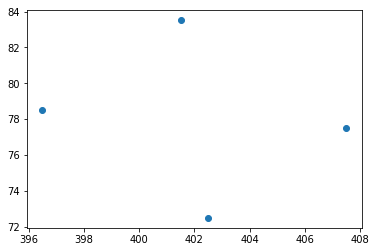

In [68]:
print(obbox[0],obbox[2])
plt.scatter(obbox.T[0],obbox.T[1])

In [95]:
np.dot(obbox[1]-obbox[0],obbox[2]-obbox[0])/np.sum((obbox[0]-obbox[2])**2)

0.59016395

In [96]:
anno['parts'][p_key]['bbox']

[74, 398, 82, 407]

In [89]:
obbox[1]-obbox[0],obbox[2]-obbox[0],

(array([ 6., -6.], dtype=float32), array([11., -1.], dtype=float32))

In [74]:
np.sqrt(np.sum((obbox[0]-obbox[2])**2))

11.045361

In [75]:
obbox[0]-obbox[2]

array([-11.,   1.], dtype=float32)

In [82]:
np.sqrt(np.sum((obbox[0]-obbox[2])**2))

11.045361